CAR FAC AGC - Cascade of Asymmetric Resonators with Fast Acting Compression and Automatic Gain Control
===

This notebook is based on Chapter 19 of Dick Lyons' [Human and Machine Hearing book](http://www.machinehearing.org). Page numbers in the code comments refer to the pages of the Author’s 2018 corrected manuscript of this book.

Notebook by André van Schaik, [International Centre for Neuromorphic Systems](https://www.westernsydney.edu.au/icns).


Now that we have added the Inner and Outer Hair Cell models, we are ready to implement the full CARFAC model from Chapter 15 shown below:

<p align="center"><img src="./images/CARFAC.png" alt="CARFAC" style="width: 600px;"></p>

To do so, we implement the following structure:

<p align="center"><img src="./images/AGC1.png" alt="AGC blocks" style="width: 600px;"></p>

The AGC filter transfer function of the combined filter loop is given by:

\begin{aligned}
H(s)&=\frac{1}{\tau_1 s+1}+\frac{2}{\left(\tau_2 s+1\right)\left(\tau_1 s+1\right)}+\frac{4}{\left(\tau_3 s+1\right)\left(\tau_2 s+1\right)\left(\tau_1 s+1\right)}+\frac{8}{\left(\tau_4 s+1\right)\left(\tau_3 s+1\right)\left(\tau_2 s+1\right)\left(\tau_1 s+1\right)} \\
& =\frac{a_3 s^3+a_2 s^2+a_1 s+a_0}{\left(\tau_4 s+1\right)\left(\tau_3 s+1\right)\left(\tau_2 s+1\right)\left(\tau_1 s+1\right)} \\
& =\frac{a_3 s^3+a_2 s^2+a_1 s+a_0}{\left(64 \tau_1 s+1\right)\left(16 \tau_1 s+1\right)\left(4 \tau_1 s+1\right)\left(\tau_1 s+1\right)} \\
\end{aligned}

with

$$\left[a_3, a_2, a_1, a_0\right]=\left[4096 \tau_1^3, 3392 \tau_1^2, 500 \tau_1, 15\right]$$

The pole locations are:

$$\left[\frac{-1}{64 \tau_1}, \frac{-1}{16 \tau_1}, \frac{-1}{4 \tau_1}, \frac{-1}{1 \tau_1}\right]$$

while the zeros are at:

$$\left[\frac{-1}{24.59 \tau_1}, \frac{-1}{7.20 \tau_1}, \frac{-1}{1.54 \tau_1}\right]$$

Each temporal filter output is also spatially filtered as shown here:

<p align="center"><img src="./images/AGC2.png" alt="AGC spatial filter" style="width: 600px;"></p>

Note, the variable $c$ was already used in Chapter 18 on the IHC, but is a different variable here. I call it $c_{AGC}$ below to avoid confusion.

Surprisingly, the spatial filtering coefficients $c_L$ and $c_R$ for the CARFAC are not given in the book. Instead, I needed to look these up in the [CARFAC code supplied by Google](https://github.com/google/carfac/blob/master/python/np/carfac.py).

The temporal filter time constants, taking into account decimation of the sampling rate at the stages $k \in [0, 3]$ are:

$$
c_{AGC}[k] =\frac{8 \times 2^k}{f_s * \tau_{AGC}}
$$

The spatial filter first defines a shift (spatial offset) and spread of the filter as:

\begin{aligned}
shiftr_{AGC}[k] &= c_{AGC}[k] \times (1.65 - 1) \times \sqrt{2}^k \\
spread_{sq\_AGC}[k] &= c_{AGC}[k] \times (1.65^2 + 1) \times 2^k \\
\end{aligned}

I do not know where the value 1.65 comes from.

Then the coefficients are calculated as:

\begin{aligned}
c_L[k] &= (spread_{sq\_AGC}[k] + {shiftr_{AGC}[k]}^2 - shiftr_{AGC}[k])/2 \\
c_R[k] &= (spread_{sq\_AGC}[k] + {shiftr_{AGC}[k]}^2 + shiftr_{AGC}[k])/2 \\
c_I[k] &= 1 - c_L[k] - c_R[k]
\end{aligned}

To measure the linearised transfer functions of the adapted cochlea, we first play a 700 Hz pure tone stimulus through the cochlea, after which we fix the value of b for each section, and then run the log sine sweep signal through the cochlea as before to measure the transfer function. First we create this stimulus and define the parameters as before. Since the role of the AGC is to increase damping, we start with very little damping.

In [1]:
%matplotlib widget
from pylab import *
from scipy import signal
import colorsys
from mpl_toolkits.mplot3d import Axes3D

fs = 48000.0                            # sample frequency
dur = 2                                 # simulation duration
npoints = int(fs * dur)                 # stimulus length

# create input tone
f0 = 700                                # tone frequency
t1 = arange(npoints) / fs               # sample times
gain = 0.1                              # input gain
stimulus = gain * sin(2 * pi * f0 * t1)

nsec = 100                              # number of sections in the cochlea between
xlow = 0.1                              # lowest frequency position along the cochlea and
xhigh = 0.9                             # highest frequency position along the cochlea
x = linspace(xhigh, xlow, nsec)         # position along the cochlea 1 = base, 0 = apex
f = 165.4 * (10**(2.1 * x) - 1)         # Greenwood for humans
a0 = cos(2 * pi * f / fs)               # a0 and c0 control the poles and zeros
c0 = sin(2 * pi * f / fs)

damping = 0.2                           # damping factor
r = 1 - damping * 2 * pi * f / fs       # pole & zero radius (actual)
r1 = 1 - damping * 2 * pi * f / fs      # pole & zero radius minimum (set point)
h = c0                                  # p285 h = c0 puts the zeros 1/2 octave above poles
g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)
                                        # p285 this gives 0dB DC gain for BM
scale = 0.1                             # p297 NLF parameter
offset = 0.04                           # p297 NLF parameter
b = 1.0                                 # automatic gain loop feedback (1=no undamping).
d_rz = 0.7 * (1 - r1)                   # p294 relative undamping

f_hpf = 20                              # p313 20Hz corner for the BM HPF
c_hpf = 1 / (1 + (2 * pi * f_hpf / fs)) # corresponding IIR coefficient 
c = 20
tau_res = 10e-3                         # p314 transmitter creation time constant
a_res = 1 / (fs * tau_res)              # p314 corresponding IIR coefficient    
tau_IHC = 80e-6                         # p314 ~8kHz LPF for IHC output
c_IHC = 1 / (fs * tau_IHC)              # p314 corresponding IIR coefficient 

Next, we add the parameters and variables for the AGC.

In [2]:
# AGC loop parameters
tau_AGC = .002 * 4**arange(4)       # p316

# The remaining parameters are found in Google code, but not in the book.
# The AGC filters are decimated, i.e., running at a lower sample rate, so the coefficients are calculated as:
c_AGC = 8 * 2**arange(4) / (fs * tau_AGC)

# spatial filtering
shiftr_AGC = c_AGC * 0.65 * np.sqrt(2)**np.arange(4)
spread_sq_AGC = c_AGC * (1.65**2 + 1) * 2**np.arange(4)
c_L = (spread_sq_AGC + shiftr_AGC**2 - shiftr_AGC)/2
c_R = (spread_sq_AGC + shiftr_AGC**2 + shiftr_AGC)/2
c_I = 1 - c_L - c_R

Before we run the simulation, we initialise the variables as needed.

In [3]:
W = zeros(nsec)                     # BM filter internal state
V = zeros(nsec)                     # BM filter internal state
Vold = zeros(nsec)                  # BM filter internal state at t-1
BM = zeros((nsec, npoints))         # BM displacement
BM_hpf = zeros((nsec, npoints))     # BM displacement high-pass filtered at 20Hz
tr_used = zeros(nsec)               # transmitter used 
tr_reservoir = ones(nsec)           # transmitter available
IHC = zeros((nsec, npoints))        # IHC output
IHCa = zeros((nsec, npoints))       # IHC filter internal state
BM[-1] = stimulus                   # put stimulus at BM[-1] to provide input to BM[0]
BM[-1, -1] = 0                      # hack to make BM_hpf[nsec-1,0] work
In8 = zeros(nsec)                   # Accumulator for ACG4
In16 = zeros(nsec)                  # Accumulator for AGC3
In32 = zeros(nsec)                  # Accumulator for AGC2
In64 = zeros(nsec)                  # Accumulator for AGC1
AGC = zeros((nsec,npoints))         # AGC filter internal state
AGC0 = zeros(nsec)                  # AGC filter internal state
AGC1 = zeros(nsec)                  # AGC filter internal state
AGC2 = zeros(nsec)                  # AGC filter internal state
AGC3 = zeros(nsec)                  # AGC filter internal state


And then we simulate the whole system for each sample time and for all cochlear sections.

In [4]:
for t in range(npoints):
    for s in range(nsec):
        Wnew = BM[s - 1, t] + r[s] * (a0[s] * W[s] - c0[s] * V[s])
        V[s] = r[s] * (a0[s] * V[s] + c0[s] * W[s])
        W[s] = Wnew
        BM[s, t] = g[s] * (BM[s-1, t] + h[s] * V[s])
    v_OHC = V - Vold
    Vold = V.copy()
    sqr = (v_OHC * scale + offset)**2
    NLF = 1 / (1 + (scale * v_OHC + offset)**2)
    r = r1 + d_rz * (1-b) * NLF
    g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)

    BM_hpf[:, t] = c_hpf * (BM_hpf[:, t-1] + BM[:, t] - BM[:, t-1])
    u = (BM_hpf[:, t] + 0.175).clip(0)  # p313
    v_mem = u**3 / (u**3 + u**2 + 0.1)  # p313, called 'g', but g is already used for the BM section gain
    tr_released = v_mem * tr_reservoir    # p313, called 'y', but renamed to avoid confusion
    tr_used = (1 - a_res) * tr_used + a_res * c * tr_released 
    tr_reservoir = 1 - tr_used            # p313, called 'v' in the book
    IHCa[:, t] = (1 - c_IHC) * IHCa[:, t-1] + c_IHC * tr_released
    IHC[:, t] = (1 - c_IHC) * IHC[:, t-1] + c_IHC * IHCa[:, t]

    In8 += IHC[:,t] / 8.0                                                       # accumulate input
    if t%64 == 0:                                                               # subsample AGC1 by factor 64
        AGC3 = (1 - c_AGC[3]) * AGC3 + c_AGC[3] * In64                          # LPF in time domain
        AGC3 = c_L[3] * roll(AGC3, 1) + c_I[3] * AGC3 + c_R[3] * roll(AGC3, -1) # LPF in spatial domain
        In64 *= 0                                                               # reset input accumulator for AGC3
    if t%32 == 0:                                                               # subsample AGC2 by factor 32
        AGC2 = (1 - c_AGC[2]) * AGC2 + c_AGC[2] * (In32 + 2 * AGC3)             # LPF in time domain
        AGC2 = c_L[2] * roll(AGC2, 1) + c_I[2] * AGC2 + c_R[2] * roll(AGC2, -1) # LPF in spatial domain
        In64 += In32                                                            # accumulate input for AGC3
        In32 *= 0                                                               # reset input accumulator for AGC2
    if t%16 == 0:                                                               # subsample ACG3 by factor 16
        AGC1 = (1 - c_AGC[1]) * AGC1 + c_AGC[1] * (In16 + 2 * AGC2)             # LPF in time domain
        AGC1 = c_L[1] * roll(AGC1, 1) + c_I[1] * AGC1 + c_R[1] * roll(AGC1, -1) # LPF in spatial domain
        In32 += In16                                                            # accumulate input for AGC2
        In16 *= 0                                                               # reset input accumulator for AGC1
    if t%8 == 0:                                                                # subsample AGC0 by factor 8
        AGC0 = (1 - c_AGC[0]) * AGC0 + c_AGC[0] * (In8 + 2 * AGC1)              # LPF in time domain
        AGC0 = c_L[0] * roll(AGC0, 1) + c_I[0] * AGC0 + c_R[0] * roll(AGC0, -1) # LPF in spatial domain
        AGC[:,t] = AGC0                                                         # store AGC output for plotting
        In16 += In8                                                             # accumulate input for AGC1
        In8 *= 0                                                                # reset input accumulator for AGC0
        b = AGC0                                                                # b of OHC is equal to AGC0
        r = r1 + d_rz * (1 - b) * NLF                                           # feedback to BM
        g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)      # gain for BM
    else:
        AGC[:,t] = AGC[:, t - 1]


After letting the cochlea adapt to the 700 Hz pure-tone stimulus, we freeze $b$, which freezes the damping of each section to the value at the end of the pure-tone stimulation. Then we play a sweep through the cochlea to measure its frequency response.

In [5]:
# Now measure the frequency response of the cochlear filters
# create a log-sine-sweep
f0 = 10                                          # sweep start frequency
f1 = fs / 2                                      # sweep end frequency
stimulus = signal.chirp(t1, f0, t1[-1], f1, method='logarithmic', phi=-90)
# wl = 1000                                        # window length
# stimulus[:wl] *= sin(linspace(0, .5 * pi, wl))   # ramp up start
# stimulus[-wl:] *= cos(linspace(0, .5 * pi, wl))  # ramp down end


# reset all these states
W0 = zeros(nsec)                 # BM filter internal state
W1 = zeros(nsec)                 # BM filter internal state
W1old = zeros(nsec)              # BM filter internal state at t-1
BM = zeros((nsec, npoints))      # BM displacement
BM_hpf = zeros((nsec, npoints))  # BM displacement high-pass filtered at 20Hz
tr_used = zeros(nsec)             # transmitter used 
tr_reservoir = ones(nsec)         # transmitter available
IHC = zeros((nsec, npoints))     # IHC output
IHCa = zeros((nsec, npoints))    # IHC filter internal state


# now play sweep through cochlea while keeping b fixed to measure the frequency response
BM[-1] = stimulus                # put stimulus at BM[-1] to provide input to BM[0]
BM[-1, -1] = 0                   # hack to make BM_hpf[nsec-1, 0] work
for t in range(npoints):
    for s in range(nsec):
        Wnew = BM[s - 1, t] + r[s] * (a0[s] * W[s] - c0[s] * V[s])
        V[s] = r[s] * (a0[s] * V[s] + c0[s] * W[s])
        W[s] = Wnew
        BM[s, t] = g[s] * (BM[s-1, t] + h[s] * V[s])
    v_OHC = V - Vold
    Vold = V.copy()
    sqr = (v_OHC * scale + offset)**2
    NLF = 1 / (1 + (scale * v_OHC + offset)**2)
    r = r1 + d_rz * (1-b) * NLF
    g = (1 - 2 * a0 * r + r * r) / (1 - (2 * a0 - h * c0) * r + r * r)

    BM_hpf[:, t] = c_hpf * (BM_hpf[:, t-1] + BM[:, t] - BM[:, t-1])
    u = (BM_hpf[:, t] + 0.175).clip(0)  # p313
    v_mem = u**3 / (u**3 + u**2 + 0.1)  # p313, called 'g', but g is already used for the BM section gain
    tr_released = v_mem * tr_reservoir    # p313, called 'y', but renamed to avoid confusion
    tr_used = (1 - a_res) * tr_used + a_res * c * tr_released 
    tr_reservoir = 1 - tr_used            # p313, called 'v' in the book
    IHCa[:, t] = (1 - c_IHC) * IHCa[:, t-1] + c_IHC * tr_released
    IHC[:, t] = (1 - c_IHC) * IHC[:, t-1] + c_IHC * IHCa[:, t]

# use the FFT of the stimulus and output directly to calculate the transfer function
FL = ceil(log2(npoints))            # define FFT length
output = BM_hpf                     # use this signal as the output signal
myFFT = fft(zeros((nsec, int(2**FL))))
for s in range(nsec):
    myFFT[s] = fft(output[s], int(2**FL)) / fft(stimulus, int(2**FL))

# calculate the BM impulse response
IR = real(ifft(myFFT))
IR[:, 0] = zeros(nsec)              # remove artefact

First we plot the same data as before: BM gain and phase response, impulse response and IHC output in response to the sweep:

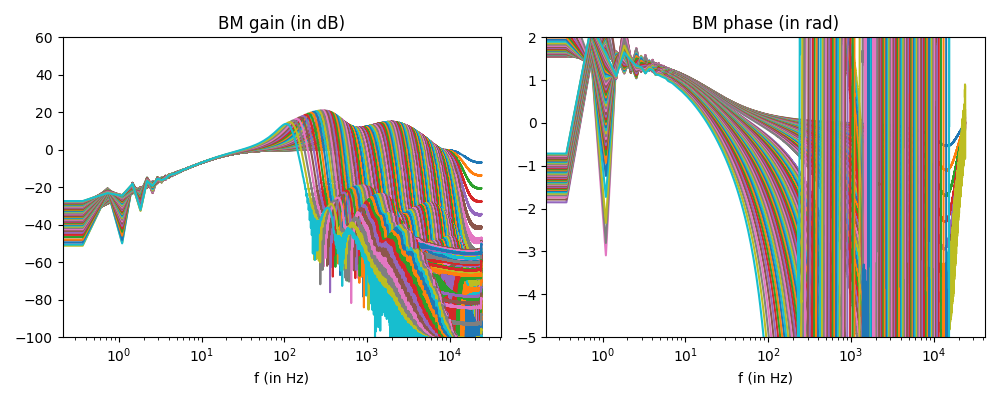

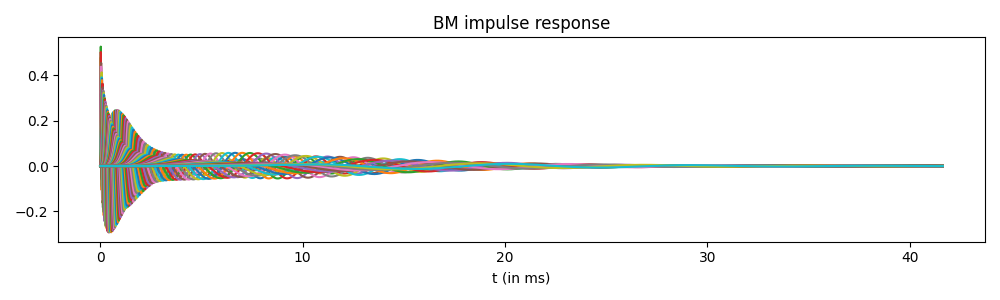

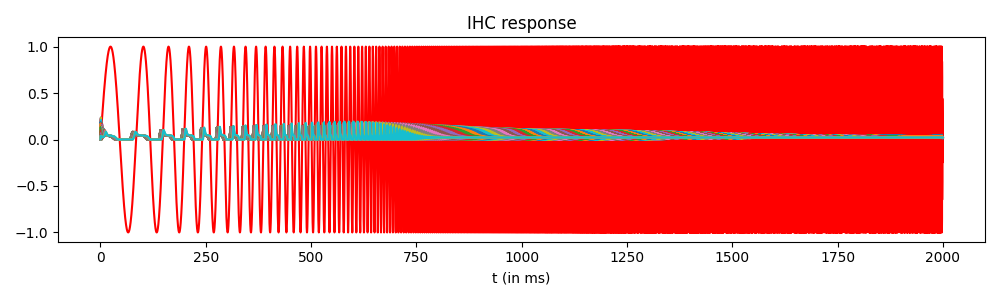

In [6]:
# plot the data

if fignum_exists(1): close(1)
figure(1, figsize=(10, 4))          # Bode plot of BM displacement 
ax1 = subplot(1, 2, 1)
freq = linspace(0, fs / 2, int((2**FL) / 2))
semilogx(freq, 20 * log10(abs(myFFT.T[0 : int((2**FL) / 2), :]) + 1e-10))
title('BM gain (in dB)')
ylim([-100, 60])
xlabel('f (in Hz)')
ax2 = subplot(1, 2, 2,sharex = ax1)
semilogx(freq, unwrap(angle(myFFT.T[0 : int((2**FL) / 2), :]), discont=5, axis=0))
title('BM phase (in rad)')
ylim([-5, 2])
xlabel('f (in Hz)')
tight_layout()

if fignum_exists(2): close(2)
figure(2, figsize=(10, 3))          # BM impulse response
L = 2000
plot(arange(L) * 1000 / fs, IR[:, 0 : L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

if fignum_exists(3): close(3)
figure(3, figsize=(10, 3))          # IHC output
plot(t1 * 1000, stimulus, 'r')
plot(t1 * 1000, IHC.T)
xlabel('t (in ms)')
title('IHC response')
tight_layout()


Note the clear dip in maximum gain for the sections that are most sensitive to frequencies near 700 Hz. Next we plot the output of the AGC loop versus section number and time. The top figure shows the 3d version of this, and the bottom figure the cross sections. You can see that the output becomes stable after 0.4s of the presentation of the pure tone.

(100, 96000)


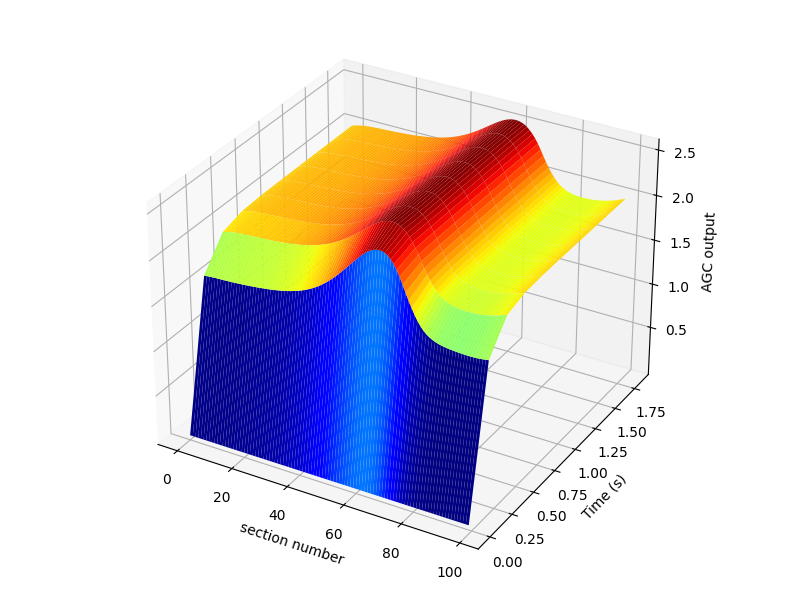

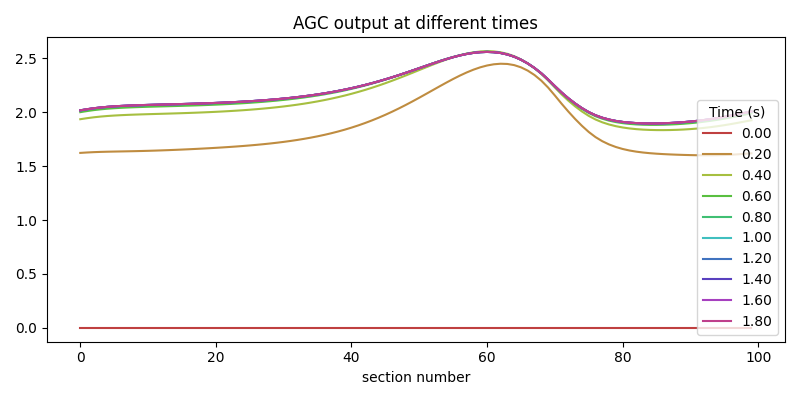

In [7]:
if fignum_exists(4): close(4)
fig = figure(4, figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
t = linspace(0, 1, 10, False) * dur
X,Y = meshgrid(linspace(0, nsec, nsec, False), t)
ax.plot_surface(X, Y, AGC[:, (t * fs).astype(int)].T, rstride=1, cstride=1, cmap=cm.jet, linewidth=0)
ax.set_xlabel("section number")
ax.set_ylabel("Time (s)")
ax.set_zlabel("AGC output")
tight_layout()

if fignum_exists(5): close(5)
figure(5, figsize=(8, 4))
for t in range(10):
    plot(AGC[:, int(t * npoints / 10)], label="%0.2f" % (t * npoints / 10 / fs), 
         color=colorsys.hls_to_rgb(t / 10.0, .5, .5))
legend(title='Time (s)', loc='lower right')
title ('AGC output at different times')
xlabel('section number')
tight_layout()
print(AGC.shape)

Finally, we plot the distribution of b across the sections at the end of the pure tone stimulation:

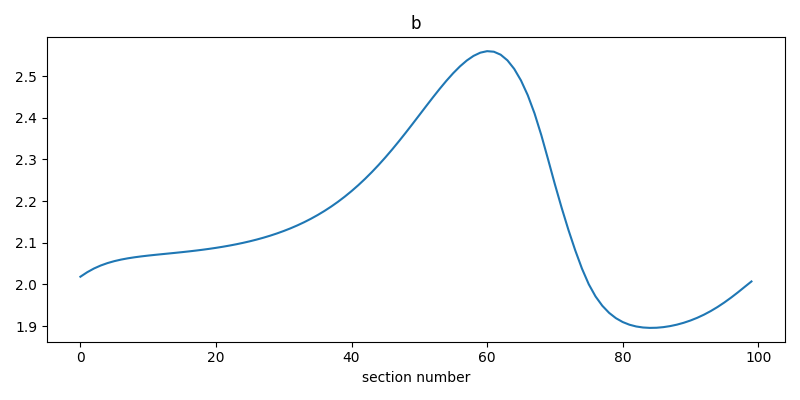

In [8]:
if fignum_exists(6): close(6)
figure(6, figsize=(8, 4))
plot(b)
title('b')
xlabel('section number')
tight_layout()

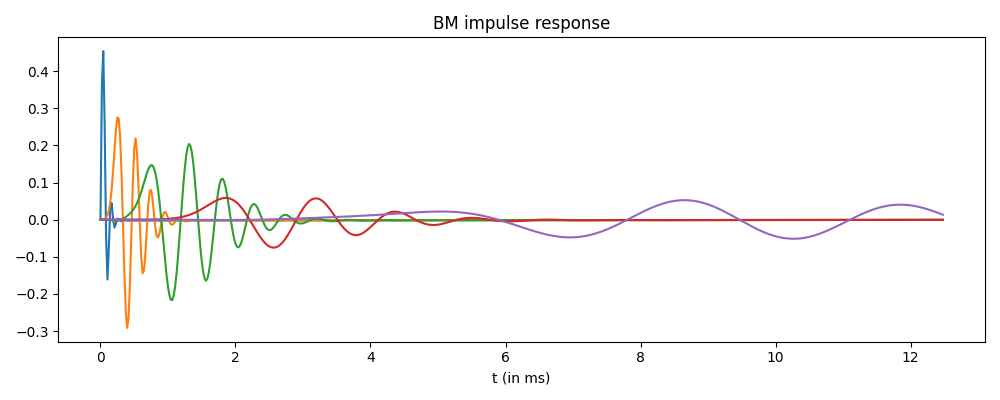

In [9]:
if fignum_exists(7): close(7)
figure(7, figsize=(10, 4))           # BM impulse response
L=600
plot(arange(L) * 1000 / fs, IR[5::20, 0 : L].T)
xlabel('t (in ms)')
title('BM impulse response')
tight_layout()

These notebooks are available at <a href="https://github.com/vschaik/CARFAC">https://github.com/vschaik/CARFAC</a>.